In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import ImageFile
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
train_data_dir = '/content/drive/My Drive/Colab Notebooks/covid_detection/dataset/train6'
valid_data_dir = '/content/drive/My Drive/Colab Notebooks/covid_detection/dataset/validation6'
test_data_dir = '/content/drive/My Drive/Colab Notebooks/covid_detection/dataset/test6'

In [ ]:
# num_class = 2
# image_dim = 224
batch_size = 8

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_data_transform = transforms.Compose([transforms.Resize(244),
                                           transforms.CenterCrop(224),
                                           transforms.RandomRotation(10),                                          
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=0.485,
                                                                std=0.229)])

valid_data_transform = transforms.Compose([transforms.Resize(244),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean= 0.485 ,std= 0.229)])

test_data_transform = transforms.Compose([transforms.Resize(224),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean= 0.485,
                                                                std= 0.229)])

train_data = datasets.ImageFolder(train_data_dir, transform=train_data_transform)
valid_data = datasets.ImageFolder(valid_data_dir, transform=valid_data_transform)
test_data = datasets.ImageFolder(test_data_dir, transform=test_data_transform)
train_data_load = DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_data_load = DataLoader(valid_data, batch_size = batch_size, shuffle = True)
test_data_load = DataLoader(test_data,batch_size=batch_size, shuffle = True)

In [ ]:
use_cuda = torch.cuda.is_available()

In [ ]:
len(valid_data_load)

25

In [ ]:
loaders_transfer = {'train': train_data_load, 'valid': valid_data_load, 'test': test_data_load}

In [ ]:
model_transfer = models.resnet50(pretrained=True)
model_transfer.out = nn.Linear(2048, 2)

if use_cuda:
    model_transfer = model_transfer.cuda() 

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.001)

In [ ]:
tl,vl,ta=[],[],[]
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        correct=0
        total=0

        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            out = model(data)
            
            loss = criterion(out, target)
            
            loss.backward()
            optimizer.step()
            train_loss += ((1/(batch_idx + 1)) * (loss.data - train_loss))
            
            _, predicted = out.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            out = model(data)
            
            loss = criterion(out, target)
            valid_loss += ((1/(batch_idx + 1)) * (loss.data - valid_loss))
            
        ta.append(100. * correct/total) 
            
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        tl.append(train_loss)
        vl.append(valid_loss)
        
        #save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Valid loss decrease to  ({:.5f} -> {:.5f}). Saving model ...'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
   
    # return trained model
    return model

In [ ]:
n_epochs = 45
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 1.04589 	Validation Loss: 1.65765
Valid loss decrease to  (inf -> 1.65765). Saving model ...
Epoch: 2 	Training Loss: 0.45549 	Validation Loss: 0.37806
Valid loss decrease to  (1.65765 -> 0.37806). Saving model ...
Epoch: 3 	Training Loss: 0.35805 	Validation Loss: 0.53637
Epoch: 4 	Training Loss: 0.41601 	Validation Loss: 0.45661
Epoch: 5 	Training Loss: 0.36674 	Validation Loss: 0.38423
Epoch: 6 	Training Loss: 0.44726 	Validation Loss: 0.46697
Epoch: 7 	Training Loss: 0.42935 	Validation Loss: 0.44213
Epoch: 8 	Training Loss: 0.35761 	Validation Loss: 0.35797
Valid loss decrease to  (0.37806 -> 0.35797). Saving model ...
Epoch: 9 	Training Loss: 0.27782 	Validation Loss: 0.34082
Valid loss decrease to  (0.35797 -> 0.34082). Saving model ...
Epoch: 10 	Training Loss: 0.40175 	Validation Loss: 0.32460
Valid loss decrease to  (0.34082 -> 0.32460). Saving model ...
Epoch: 11 	Training Loss: 0.29355 	Validation Loss: 0.70306
Epoch: 12 	Training Loss: 0.31441 	Val

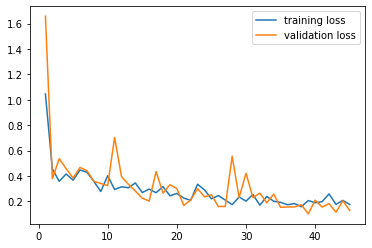

In [ ]:
tl1=[]
vl1=[]
a=[]
for i in tl:
    tl1.append(float(i))
for i in vl:
    vl1.append(float(i))
for i in range(1,46):
    a.append(i)
plt.plot(a,tl1,label='training loss')
plt.plot(a,vl1,label='validation loss')
plt.legend()

94.66666666666667

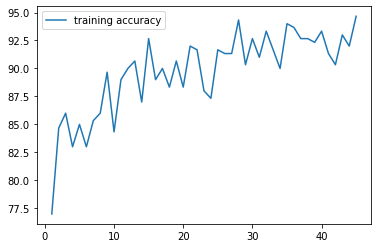

In [ ]:
ta1=[]
for i in ta:
    ta1.append(float(i))
plt.plot(a,ta1,label='training accuracy')
plt.legend()
ta1[-1]

In [ ]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

In [ ]:
testa,testl=[],[]
def test(loaders, model, criterion, use_cuda):

    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target) 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
        print('Test Loss: {:.6f}\n'.format(test_loss))
        testl.append(float(test_loss))

        print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
            100. * correct / total, correct, total))
        testa.append(100. * correct / total)
        print('')

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.315224


Test Accuracy: 87% ( 7/ 8)

Test Loss: 0.515792


Test Accuracy: 87% (14/16)

Test Loss: 0.347228


Test Accuracy: 91% (22/24)

Test Loss: 0.285168


Test Accuracy: 93% (30/32)

Test Loss: 0.296613


Test Accuracy: 92% (37/40)

Test Loss: 0.291883


Test Accuracy: 91% (44/48)

Test Loss: 0.286042


Test Accuracy: 91% (51/56)

Test Loss: 0.296031


Test Accuracy: 90% (58/64)

Test Loss: 0.312081


Test Accuracy: 88% (64/72)

Test Loss: 0.282068


Test Accuracy: 90% (72/80)

Test Loss: 0.322991


Test Accuracy: 86% (76/88)

Test Loss: 0.310984


Test Accuracy: 86% (83/96)

Test Loss: 0.287643


Test Accuracy: 87% (91/104)

Test Loss: 0.273378


Test Accuracy: 88% (99/112)

Test Loss: 0.270791


Test Accuracy: 88% (106/120)

Test Loss: 0.267466


Test Accuracy: 89% (114/128)

Test Loss: 0.260183


Test Accuracy: 88% (121/136)

Test Loss: 0.248275


Test Accuracy: 89% (129/144)

Test Loss: 0.240634


Test Accuracy: 90% (137/152)

Test Loss: 0.231984


Test Accuracy: 9

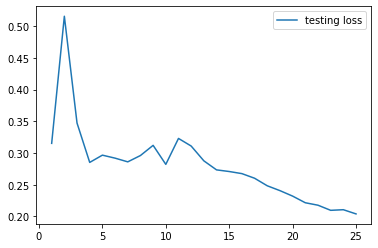

In [ ]:
testl1=[]
a=[]
for i in testl:
    testl1.append(float(i))
for i in range(len(testl1)):
    a.append(i+1)
plt.plot(a,testl1,label='testing loss')
plt.legend()

92.0


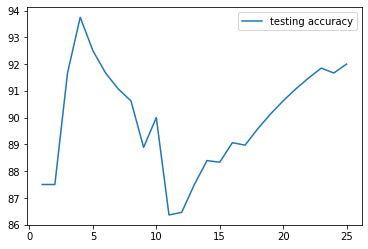

In [ ]:
testa1=[]
for i in testa:
    testa1.append(float(i))
print(testa1[-1])
plt.plot(a,testa1,label='testing accuracy')
plt.legend()